- ユビキチン（Ubiquitin）
　- PDB ID: 1UBQ

- ミオグロビン（Myoglobin）
　- PDB ID: 1MBN

- リゾチーム（Lysozyme）
　- PDB ID: 1LYZ

- シトクロムC（Cytochrome c）
　- PDB ID: 1HRC

- トリプシン（Trypsin）
　- PDB ID: 2PTN

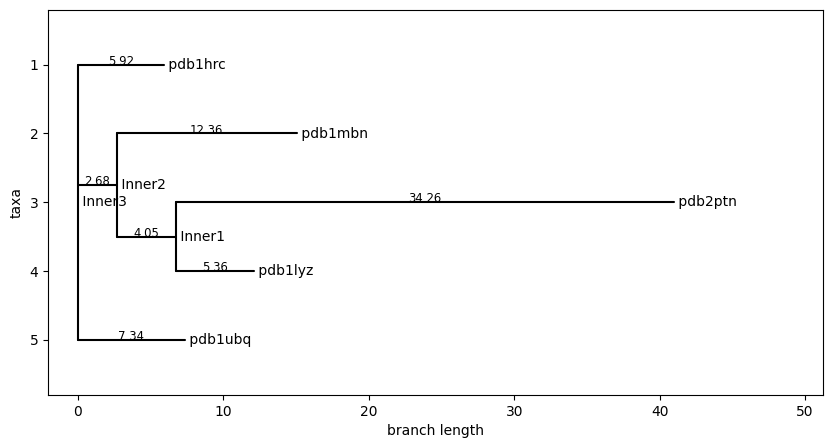

In [6]:
import os
from Bio.PDB import PDBParser
from gudhi import RipsComplex
from gudhi.wasserstein import wasserstein_distance
import matplotlib.pyplot as plt
import numpy as np
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
from Bio import Phylo

# 1. PDBファイルリスト
pdb_dir = "pdbfiles"
pdb_files = [os.path.join(pdb_dir, f) for f in os.listdir(pdb_dir) if f.endswith(".ent")]
names = [os.path.splitext(os.path.basename(f))[0] for f in pdb_files]

# 2. Cα座標抽出
def extract_ca_coords(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('protein', pdb_file)
    coords = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:
                    coords.append(residue['CA'].coord)
    return coords

# 3. パーシステンスダイアグラム計算
def compute_pd(coords, max_edge_length=20.0, max_dimension=2):
    rips_complex = RipsComplex(points=coords, max_edge_length=max_edge_length)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)
    diag = simplex_tree.persistence()
    # H1のみ抽出
    pd = simplex_tree.persistence_intervals_in_dimension(1)
    return pd

# 4. 各タンパク質のPDを計算
pds = []
for pdb in pdb_files:
    coords = extract_ca_coords(pdb)
    pd = compute_pd(coords)
    pds.append(pd)

# 5. 距離行列作成（ワッサースタイン距離）
n = len(pds)
dist_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i):
        d = wasserstein_distance(pds[i], pds[j], order=1.)
        dist_matrix[i, j] = dist_matrix[j, i] = d

# 6. Bio.Phylo用の下三角行列に変換
lower_triangle = []
for i in range(n):
    lower_triangle.append([dist_matrix[i][j] for j in range(i+1)])

dm = DistanceMatrix(names, lower_triangle)
constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)

# 7. 付加情報もりもりで系統樹を表示
fig = plt.figure(figsize=(10, 5))
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes, branch_labels=lambda c: f"{c.branch_length:.2f}" if c.branch_length else "")